In [29]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np

In [30]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [31]:
transactions_products = pd.merge(transactions, products, on='ProductID', how='left')

data = pd.merge(transactions_products, customers, on='CustomerID', how='left')
data = data.drop(columns=['Price_y'])
data.rename(columns={'Price_x': 'Price'}, inplace=True)

In [32]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,ProductName,Category,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,Timothy Perez,Europe,2022-03-15


In [33]:
customer_features = (
    data.groupby('CustomerID')
    .agg(
        avg_transaction_value=('TotalValue', 'mean'),
        total_purchases=('TransactionID', 'count'),
        total_quantity=('Quantity', 'sum'),
        avg_price_per_product=('Price', 'mean'),
    )
    .reset_index()
)
customer_features

,CustomerID,avg_transaction_value,total_purchases,total_quantity,avg_price_per_product
0,C0001,670.904000,5,12,278.334000
1,C0002,465.685000,4,10,208.920000
2,C0003,681.345000,4,14,195.707500
3,C0004,669.360000,8,23,240.636250
4,C0005,678.080000,3,7,291.603333
...,...,...,...,...,...
194,C0196,1245.720000,4,12,416.992500
195,C0197,642.883333,3,9,227.056667
196,C0198,465.915000,2,3,239.705000
197,C0199,494.820000,4,9,250.610000


In [34]:
category_pivot = pd.pivot_table(
    data, values='Quantity', index='CustomerID', columns='Category', aggfunc='sum', fill_value=0
)
category_pivot.reset_index(inplace=True)

customer_profiles = pd.merge(customer_features, category_pivot, on='CustomerID', how='left')

scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_profiles.drop(columns=['CustomerID']))
customer_profiles

,CustomerID,avg_transaction_value,total_purchases,total_quantity,avg_price_per_product,Books,Clothing,Electronics,Home Decor
0,C0001,670.904000,5,12,278.334000,2,0,7,3
1,C0002,465.685000,4,10,208.920000,0,4,0,6
2,C0003,681.345000,4,14,195.707500,0,4,4,6
3,C0004,669.360000,8,23,240.636250,8,0,6,9
4,C0005,678.080000,3,7,291.603333,0,0,4,3
...,...,...,...,...,...,...,...,...,...
194,C0196,1245.720000,4,12,416.992500,3,4,0,5
195,C0197,642.883333,3,9,227.056667,0,0,6,3
196,C0198,465.915000,2,3,239.705000,0,2,1,0
197,C0199,494.820000,4,9,250.610000,0,0,3,6


In [35]:
similarity_matrix = cosine_similarity(normalized_features)

In [36]:
customer_ids = customer_profiles['CustomerID'].tolist()
lookalikes = {}

for idx, customer_id in enumerate(customer_ids[:20]):
    scores = similarity_matrix[idx]
    top_3_indices = scores.argsort()[-4:-1][::-1]
    similar_customers = [(customer_ids[i], scores[i]) for i in top_3_indices]
    lookalikes[customer_id] = similar_customers

In [37]:
lookalike_data = [
    {"CustomerID": cust_id, "Lookalikes": str(similar_cust)}
    for cust_id, similar_cust in lookalikes.items()
]

lookalike_df = pd.DataFrame(lookalike_data)
lookalike_df.to_csv('Lookalike.csv', index=False)

print("Lookalike Model completed. Results saved to Lookalike.csv")

Lookalike Model completed. Results saved to Lookalike.csv


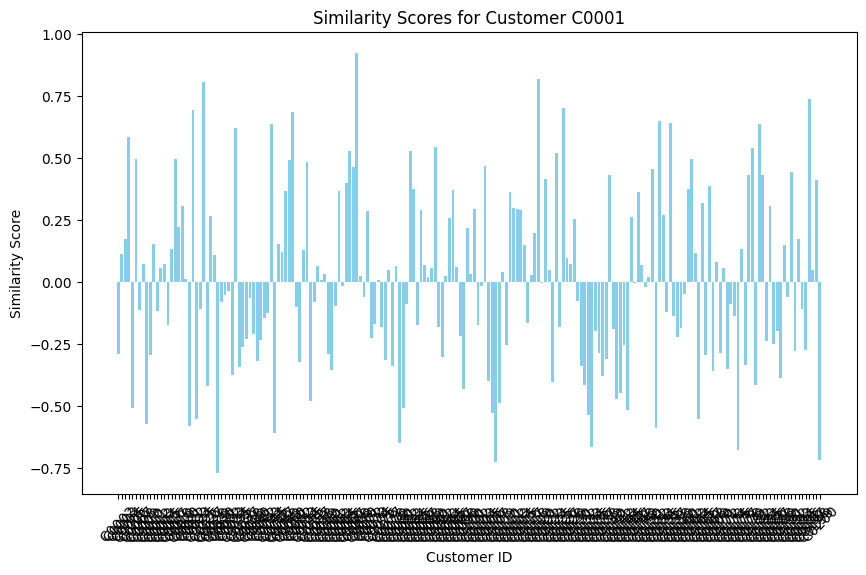

In [38]:
import matplotlib.pyplot as plt

first_customer = customer_ids[0]
first_customer_scores = similarity_matrix[0]

plt.figure(figsize=(10, 6))
plt.bar(
    [customer_ids[i] for i in range(len(customer_ids)) if i != 0],
    [first_customer_scores[i] for i in range(len(customer_ids)) if i != 0],
    color='skyblue'
)
plt.title(f"Similarity Scores for Customer {first_customer}")
plt.xlabel("Customer ID")
plt.ylabel("Similarity Score")
plt.xticks(rotation=45)
plt.show()

In [39]:
df = pd.read_csv('Kumar_Anmol_Lookalike.csv')
df

,CustomerID,Lookalikes
0,C0001,"[('C0069', 0.9240821124233313), ('C0120', 0.82..."
1,C0002,"[('C0031', 0.9194518141437513), ('C0178', 0.88..."
2,C0003,"[('C0195', 0.7706151995492583), ('C0166', 0.72..."
3,C0004,"[('C0065', 0.9468072721016626), ('C0075', 0.93..."
4,C0005,"[('C0130', 0.8727877616346875), ('C0140', 0.86..."
5,C0006,"[('C0185', 0.9135063144195097), ('C0196', 0.89..."
6,C0007,"[('C0085', 0.9683323408290174), ('C0005', 0.86..."
7,C0008,"[('C0093', 0.9165858445945622), ('C0194', 0.84..."
8,C0009,"[('C0198', 0.9196934529411189), ('C0128', 0.90..."
9,C0010,"[('C0030', 0.9149889562704936), ('C0077', 0.86..."


In [40]:
df['Lookalikes'][0]

"[('C0069', 0.9240821124233313), ('C0120', 0.8203200574121282), ('C0026', 0.8078297482642658)]"